## Analysing Smartwatch Data

This notebook gives an overview of how to use HeartPy in the analysis of raw PPG data taken from a commercial (Samsung) smartwatch device.

A signal measured this way contains a lot more noise when compared to a typical PPG sensor on the fingertip or earlobe, where perfusion is much easier to measure than on the wrist.

Analysing such a signal requires some additional steps as described in this notebook.

First let's load up the dependencies and the data file

In [84]:
import numpy as np

import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('mouaadh_with_wrist_low.csv')

In [85]:
df.keys()

Index(['hr', 'red', 'datetime'], dtype='object')

#### Exploring data file

Let's explore the data file to get an idea of what we're working with.

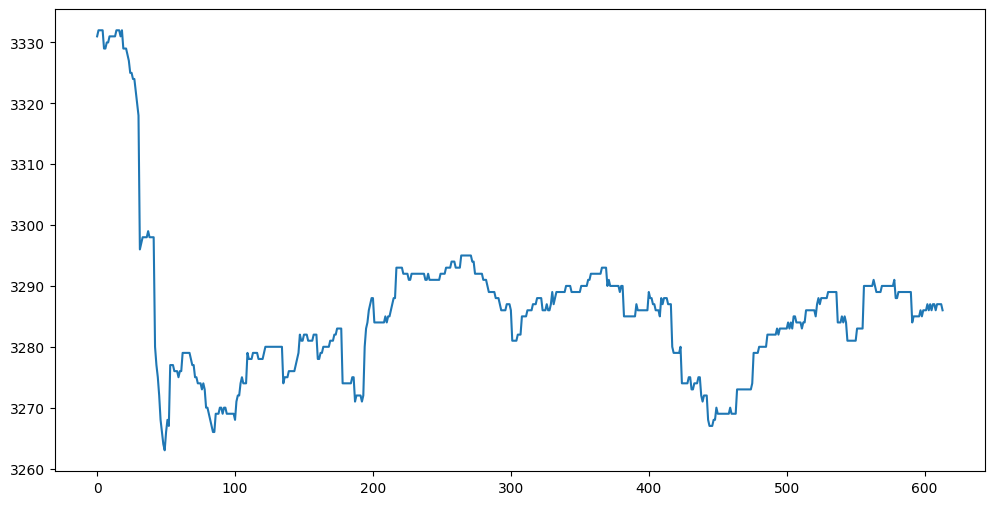

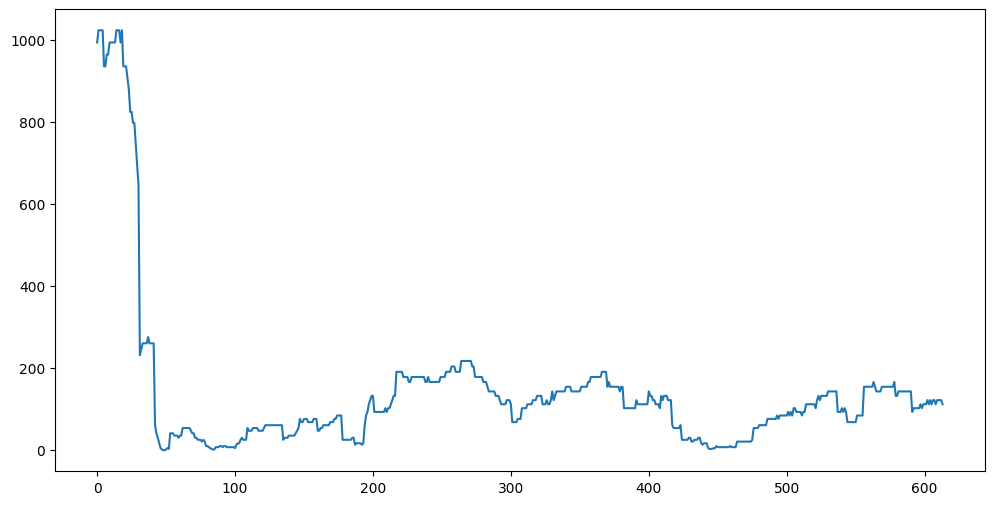

AttributeError: module 'HeartPy' has no attribute 'butter_lowpass_filter'

In [88]:
plt.figure(figsize=(12,6))

plt.plot(df['hr'].values)
plt.show()


enhanced = hp.enhance_peaks(df['hr'], iterations=2)

plt.figure(figsize=(12,6))
plt.plot(enhanced)
plt.show()


filtered = hp.butter_lowpass_filter(df['hr'], cutoff=5, sample_rate=100.0, order=3)
plt.figure(figsize=(12,6))
plt.plot(filtered)
plt.show()

#### Ok..

There seems to be intermittent sections of PPG dotted between non-signals (periods where the sensor was not recording). 

For now let's slice the first signal section and see what's up. Later on I'll show you how to exclude non-signal sections automatically.

[1883655 1883662 1883677 ... 4197855 4197833 4197840]
[2348963 2349602 2348257 ... 2298045 2296519 2296364]
['11:10:57.978' '11:10:58.078' '11:10:58.178' ... '11:20:58.632'
 '11:20:58.732' '11:20:58.832']


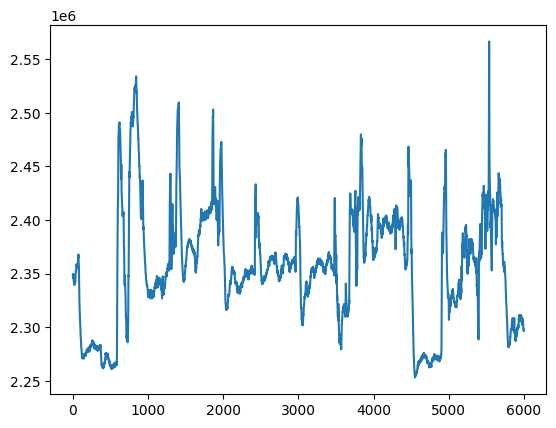

In [19]:
signal = df['ppg'].values[14500:20500]
print(df['ppg'].values)
print(signal)
timer = df['timer'].values[14500:20500]
print(timer)
plt.plot(signal)
plt.show()

#### Now we need to know the sampling rate

The sampling rate is the one measure to rule them all. It is used to compute all others.

HeartPy has several ways of getting the sample rate from timer columns. Let's look at the format of the timer column to see what we're working with.

In [5]:
timer[0:20]

array(['11:10:57.978', '11:10:58.078', '11:10:58.178', '11:10:58.279',
       '11:10:58.379', '11:10:58.479', '11:10:58.579', '11:10:58.679',
       '11:10:58.779', '11:10:58.879', '11:10:58.980', '11:10:59.092',
       '11:10:59.180', '11:10:59.283', '11:10:59.381', '11:10:59.481',
       '11:10:59.582', '11:10:59.681', '11:10:59.781', '11:10:59.882'],
      dtype=object)

So, the format seems to be **'hours:minutes:seconds.miliseconds'**

HeartPy comes with a datetime function that can work with date- and time-strings called *get_samplerate_datetime*. Check the help to see how it works:

In [6]:
help(hp.get_samplerate_datetime)

Help on function get_samplerate_datetime in module heartpy.datautils:

get_samplerate_datetime(datetimedata, timeformat='%H:%M:%S.%f')
    determine sample rate based on datetime
    
    Function to determine sample rate of data from datetime-based timer
    list or array.
    
    Parameters
    ----------
    timerdata : 1-d numpy array or list
        sequence containing datetime strings
    
    timeformat : string
        the format of the datetime-strings in datetimedata
        default : '%H:%M:%S.f' (24-hour based time including ms: e.g. 21:43:12.569)
    
    Returns
    -------
    out : float
        the sample rate as determined from the timer sequence provided
    
    Examples
    --------
    We load the data like before
    
    >>> data, timer = load_exampledata(example = 2)
    >>> timer[0]
    '2016-11-24 13:58:58.081000'
    
    Note that we need to specify the timeformat used so that datetime understands
    what it's working with:
    
    >>> round(get_samplera

In [20]:
#Seems easy enough, right? Now let's determine the sample rate

sample_rate = hp.get_samplerate_datetime(timer, timeformat = '%H:%M:%S.%f')

print('sampling rate is: %.3f Hz' %sample_rate)

sampling rate is: 9.986 Hz


### That's pretty low.

The sample rate is quite low but to conserve power this is what many smart watches work with. For determining the BPM this is just fine, but any heart rate variability (HRV) measures are likely not going to be super accurate. Depending on your needs it may still be fine, though.

A **second consideration** with sampling rate is whether it's stable or not. Many devices including smart watches do many things at once. They run an OS that has other tasks besides measuring heart rate, so when measuring at 10Hz, the OS might not be ready exactly every 100ms to get a measurement. As such, the sampling rate might vary. Let's visualise this. 

[datetime.datetime(1900, 1, 1, 11, 10, 57, 978000), datetime.datetime(1900, 1, 1, 11, 10, 58, 78000), datetime.datetime(1900, 1, 1, 11, 10, 58, 178000), datetime.datetime(1900, 1, 1, 11, 10, 58, 279000), datetime.datetime(1900, 1, 1, 11, 10, 58, 379000), datetime.datetime(1900, 1, 1, 11, 10, 58, 479000), datetime.datetime(1900, 1, 1, 11, 10, 58, 579000), datetime.datetime(1900, 1, 1, 11, 10, 58, 679000), datetime.datetime(1900, 1, 1, 11, 10, 58, 779000), datetime.datetime(1900, 1, 1, 11, 10, 58, 879000), datetime.datetime(1900, 1, 1, 11, 10, 58, 980000), datetime.datetime(1900, 1, 1, 11, 10, 59, 92000), datetime.datetime(1900, 1, 1, 11, 10, 59, 180000), datetime.datetime(1900, 1, 1, 11, 10, 59, 283000), datetime.datetime(1900, 1, 1, 11, 10, 59, 381000), datetime.datetime(1900, 1, 1, 11, 10, 59, 481000), datetime.datetime(1900, 1, 1, 11, 10, 59, 582000), datetime.datetime(1900, 1, 1, 11, 10, 59, 681000), datetime.datetime(1900, 1, 1, 11, 10, 59, 781000), datetime.datetime(1900, 1, 1, 11

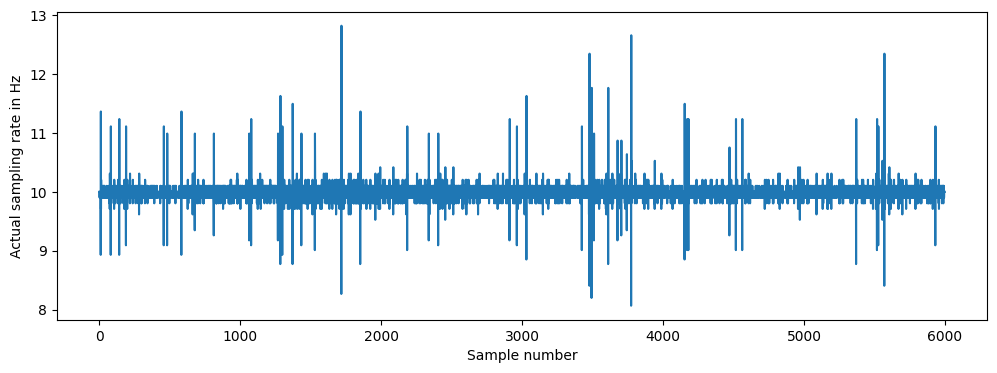

mean sampling rate: 9.987
median sampling rate: 10.000
standard deviation: 0.183


In [22]:
from datetime import datetime

#let's create a list 'newtimer' to house our datetime objects
newtimer = [datetime.strptime(x, '%H:%M:%S.%f') for x in timer]
print(newtimer)
#let's compute the real distances from entry to entry
elapsed = []
for i in range(len(newtimer) - 1):
    elapsed.append(1 / ((newtimer[i+1] - newtimer[i]).microseconds / 1000000))

#and plot the results
plt.figure(figsize=(12,4))
plt.plot(elapsed)
plt.xlabel('Sample number')
plt.ylabel('Actual sampling rate in Hz')
plt.show()

print('mean sampling rate: %.3f' %np.mean(elapsed))
print('median sampling rate: %.3f'%np.median(elapsed))
print('standard deviation: %.3f'%np.std(elapsed))

### That's actually not bad!

The signal mean is close to 10Hz and shows a low variance. Sporadic peaks to 12Hz or dips to 9Hz indicate timer inaccuracies but they are infrequent.

For our current purposes this is just fine.

You could of course interpolate and resample the signal so that it has an exact sampling rate but the effects on computed measures are likely minimal. For now let's just continue on.

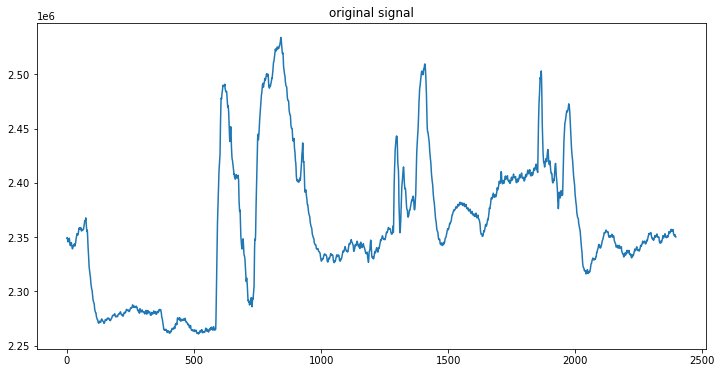

In [9]:
#Let's plot 4 minutes of the segment we selected to get a view 
#of what we're working with
plt.figure(figsize=(12,6))
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.show()

The first thing to note is that amplitude varies dramatically. Let's run it through a bandpass filter and take out all frequencies that definitely are not heart rate.

We'll take out frequencies below 0.7Hz (42 BPM) and above 3.5 Hz (210 BPM). 

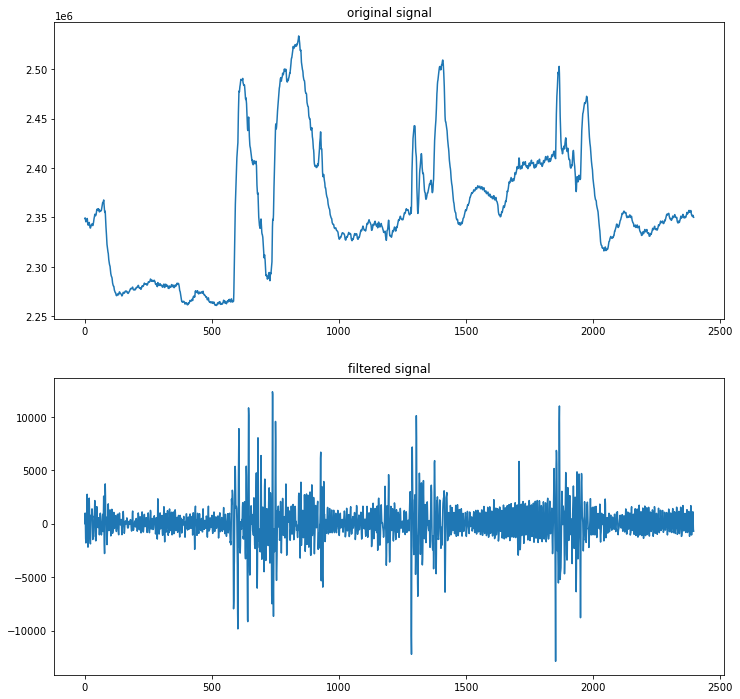

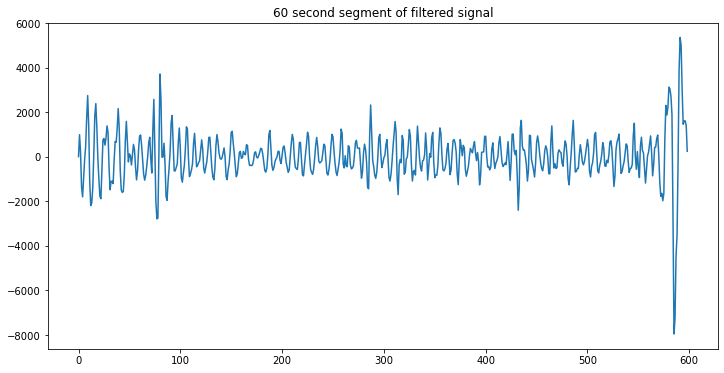

In [10]:
#Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
filtered = hp.filter_signal(signal, [0.7, 3.5], sample_rate=sample_rate, 
                            order=3, filtertype='bandpass')

#let's plot first 240 seconds and work with that!
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(signal[0:int(240 * sample_rate)])
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered[0:int(240 * sample_rate)])
plt.title('filtered signal')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered[0:int(sample_rate * 60)])
plt.title('60 second segment of filtered signal')
plt.show()

#### Still low quality but at least the heart rate is quite visible now!

In [11]:
#let's resample to ~100Hz as well
#10Hz is low for the adaptive threshold analysis HeartPy uses
from scipy.signal import resample

resampled = resample(filtered, len(filtered) * 10)

#don't forget to compute the new sampling rate
new_sample_rate = sample_rate * 10

c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:298: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


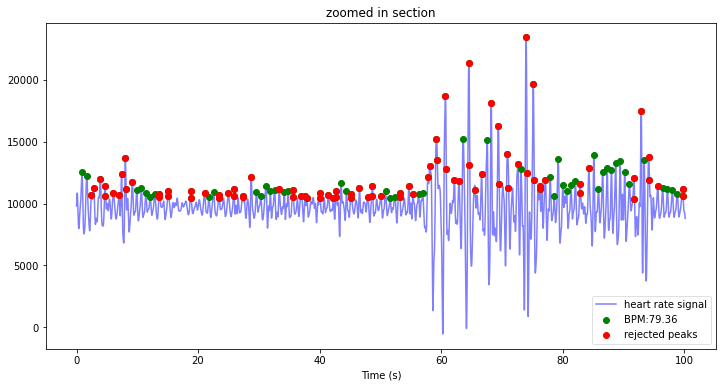

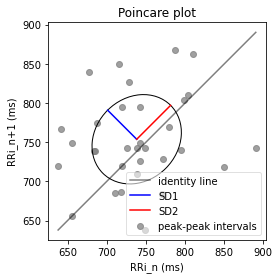

bpm: 79.359496
ibi: 756.053189
sdnn: 64.994392
sdsd: 47.662905
rmssd: 75.816447
pnn20: 0.687500
pnn50: 0.562500
hr_mad: 38.056933
sd1: 52.474660
sd2: 61.238831
s: 10095.466648
sd1/sd2: 0.856885
breathingrate: 0.166667


c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:298: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


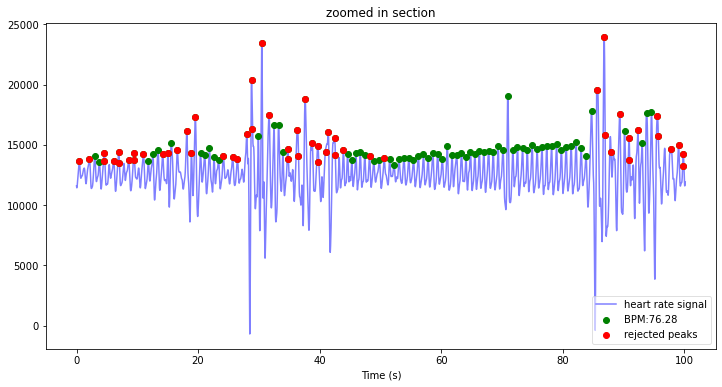

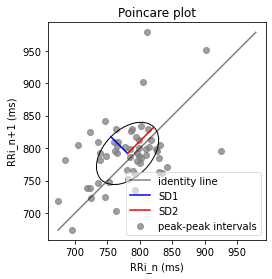

bpm: 76.276784
ibi: 786.608936
sdnn: 64.426442
sdsd: 33.842026
rmssd: 52.451344
pnn20: 0.706897
pnn50: 0.258621
hr_mad: 25.028467
sd1: 36.269742
sd2: 57.296852
s: 6528.675837
sd1/sd2: 0.633015
breathingrate: 0.233333


c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:298: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


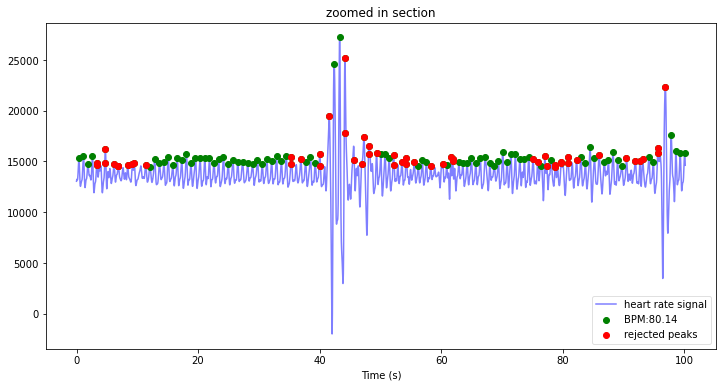

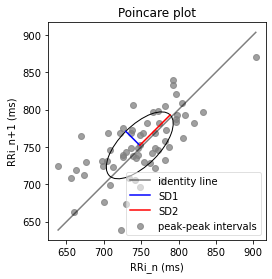

bpm: 80.140527
ibi: 748.684870
sdnn: 47.606192
sdsd: 21.648073
rmssd: 37.633326
pnn20: 0.646154
pnn50: 0.184615
hr_mad: 27.042700
sd1: 26.454880
sd2: 57.468399
s: 4776.224835
sd1/sd2: 0.460338
breathingrate: 0.200000


c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:298: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


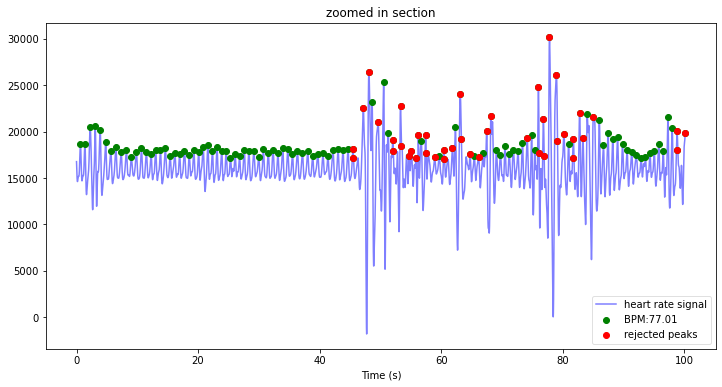

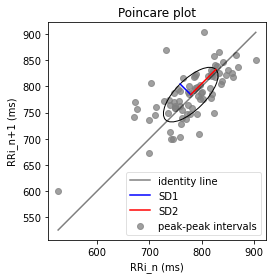

bpm: 77.007966
ibi: 779.140179
sdnn: 67.149279
sdsd: 26.025919
rmssd: 40.921120
pnn20: 0.620253
pnn50: 0.151899
hr_mad: 35.549817
sd1: 28.690814
sd2: 67.970221
s: 6126.485560
sd1/sd2: 0.422109
breathingrate: 0.266667


c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\python37\lib\site-packages\heartpy-1.2.6-py3.7.egg\heartpy\visualizeutils.py:298: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


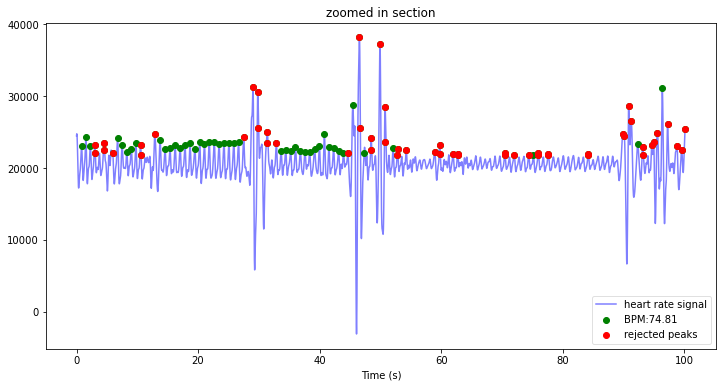

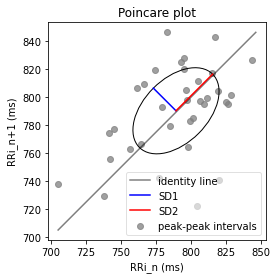

bpm: 74.808472
ibi: 802.048196
sdnn: 72.275896
sdsd: 19.707483
rmssd: 32.333149
pnn20: 0.514286
pnn50: 0.085714
hr_mad: 23.028467
sd1: 22.852642
sd2: 37.011862
s: 2657.218189
sd1/sd2: 0.617441
breathingrate: 0.266667


In [12]:
#run HeartPy over a few segments, fingers crossed, and plot results of each
for s in [[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]]:
    wd, m = hp.process(resampled[s[0]:s[1]], sample_rate = new_sample_rate, 
                       high_precision=True, clean_rr=True)
    hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
    hp.plot_poincare(wd, m)
    plt.show()
    for measure in m.keys():
        print('%s: %f' %(measure, m[measure]))

#### That seems a reasonable result. By far the most peaks are marked correctly, and most peaksin noisy sections (low confidence) are simply rejected.

clean_rr uses by default quotient-filtering, which is a bit aggressive.

You can set 'iqr' or 'z-score' with the clean_rr_method flag.

### Finally let's look at a way to extract signal section and exclude non-signal sections automatically.

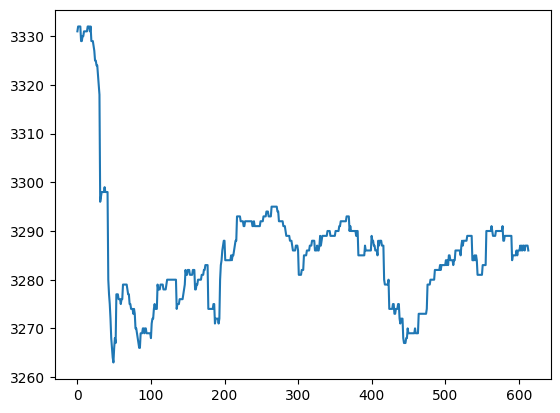

In [75]:
raw = df['hr'].values

plt.plot(raw)
plt.show()

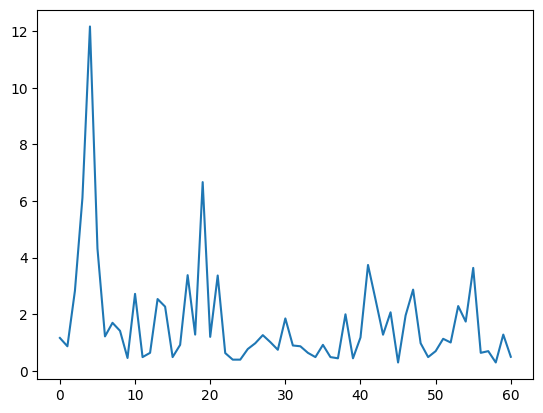

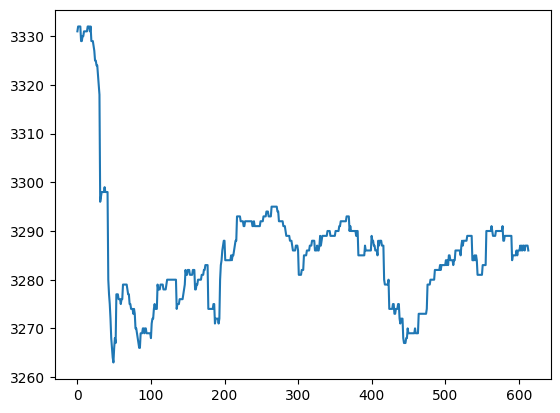

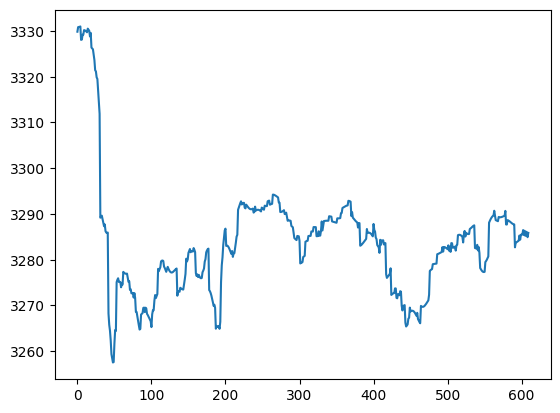

In [77]:
import sys
from scipy.signal import resample

windowsize = 10
std = []

for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    try:
        std.append(np.std(sliced))
    except:
        print(i)
    
plt.plot(std)
plt.show()

plt.plot(raw)
plt.show()

plt.plot(raw[0:(len(raw) // windowsize) * windowsize] - resample(std, len(std)*windowsize))
plt.show()

#### Hmmm, not much luck yet, but an idea:

In [78]:
(len(raw) // windowsize) * windowsize

610

3332 3263
614
3
sliced:  [3331 3332 3332 3332 3332 3329 3329 3330 3330 3331]
3331
3332
3332
3332
3332
3329
3329
3330
3330
3331
3
sliced:  [3331 3331 3331 3331 3332 3332 3332 3331 3332 3329]
3331
3331
3331
3331
3332
3332
3332
3331
3332
3329
9
sliced:  [3329 3329 3328 3327 3325 3325 3324 3324 3322 3320]
3329
3329
3328
3327
3325
3325
3324
3324
3322
3320
22
sliced:  [3318 3296 3297 3298 3298 3298 3298 3299 3298 3298]
3318
3296
3297
3298
3298
3298
3298
3299
3298
3298
35
sliced:  [3298 3298 3280 3277 3275 3272 3268 3266 3264 3263]
3298
3298
3280
3277
3275
3272
3268
3266
3264
3263
11
sliced:  [3266 3268 3267 3277 3277 3277 3276 3276 3276 3275]
3266
3268
3267
3277
3277
3277
3276
3276
3276
3275
3
sliced:  [3276 3276 3279 3279 3279 3279 3279 3279 3278 3277]
3276
3276
3279
3279
3279
3279
3279
3279
3278
3277
7
sliced:  [3277 3275 3275 3274 3274 3274 3273 3274 3273 3270]
3277
3275
3275
3274
3274
3274
3273
3274
3273
3270
4
sliced:  [3270 3269 3268 3267 3266 3266 3269 3269 3269 3270]
3270
3269
3268
3

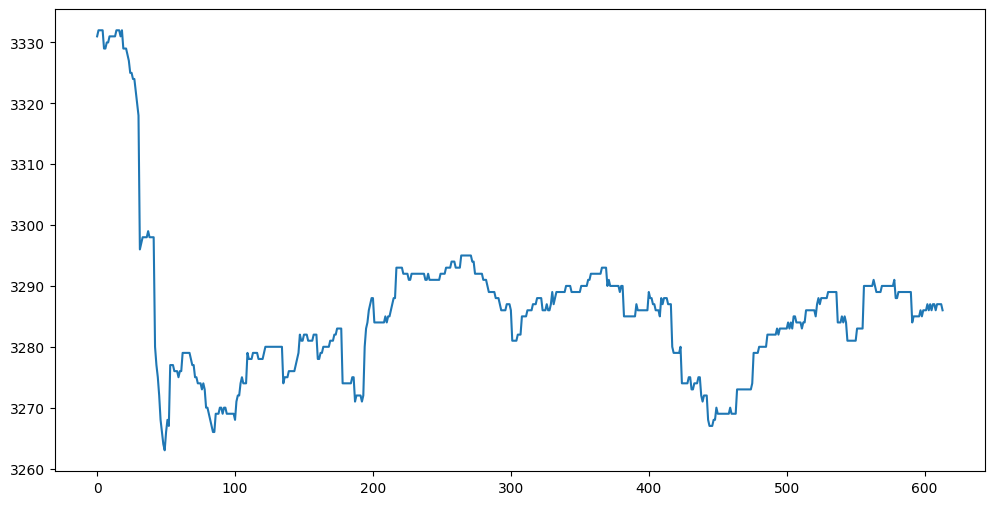

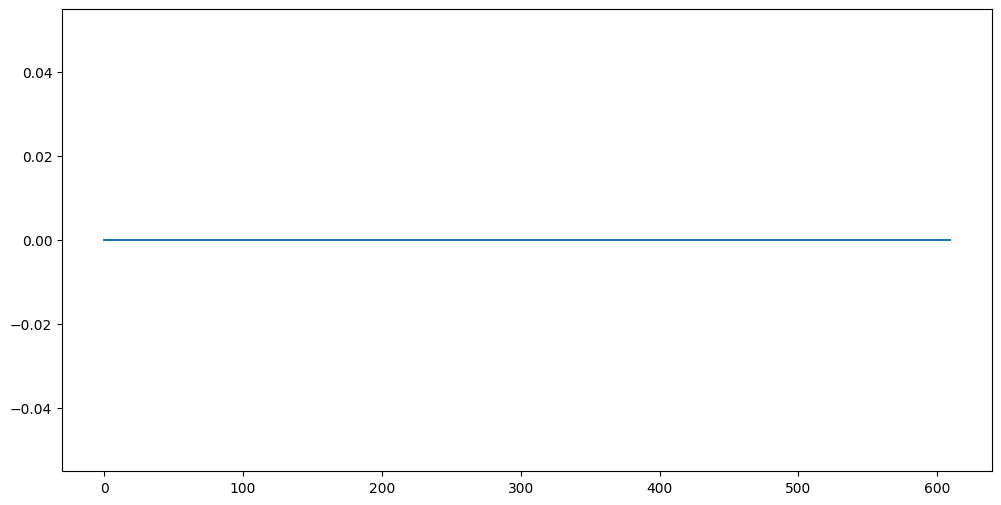

In [80]:
mx = np.max(raw)
mn = np.min(raw)
print(mx, mn)
global_range = mx - mn

windowsize = 10
filtered = []
print (len(raw))
for i in range(len(raw) // windowsize):
    start = i * windowsize
    end = (i + 1) * windowsize
    sliced = raw[start:end]
    rng = np.max(sliced) - np.min(sliced)
    print(rng)
    if ((rng >= (0.5 * global_range)) 
        or 
        (np.max(sliced) >= 0.9 * mx) 
        or 
        (np.min(sliced) <= mn + (0.1 * mn))):
        # print("iam here")
        print("sliced: ", sliced)
        for x in sliced:
            print(x)
            filtered.append(0)
    else:
        for x in sliced:
            filtered.append(x)

print("filtered: ", filtered)
plt.figure(figsize=(12,6))
plt.plot(raw)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(filtered)
plt.show()


### That works! A quick and dirty automatic extraction of signal sections

For this we use a window function and for each window test whether it:

-	Has a range that is at least 50% of range of the raw signal
-	OR
-	Has a maximum that is 90% the raw signal’s maximum
-	OR
-	Has a minimum that is the minimum + 10% of the raw signal

This works well enough